# 1) Imports

In [1]:
# Core
import os
import random
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, resnet50

# Utilities
from tqdm import tqdm

2026-02-13 18:33:30.015890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771007610.181704      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771007610.228582      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771007610.623025      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771007610.623070      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771007610.623073      55 computation_placer.cc:177] computation placer alr

# 2) Dataset Paths

In [2]:
# All folders directly containing images
CLASS_FOLDERS = {
    "glioma": [
        "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/glioma",
        "/kaggle/input/brain-tumor-mri-scans/glioma",
        "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma",
        "/kaggle/input/brain-tumor-mri-dataset/Training/glioma",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/Train/Train/Glioma/images",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/test/test/Glioma/images",
        "/kaggle/input/brain-tumor-classification/Testing/glioma_tumor",
        "/kaggle/input/brain-tumor-classification/Training/glioma_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor",
        "/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor"
    ],
    "meningioma": [
        "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/meningioma",
        "/kaggle/input/brain-tumor-mri-scans/meningioma",
        "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma",
        "/kaggle/input/brain-tumor-mri-dataset/Training/meningioma",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/Train/Train/Meningioma/images",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/test/test/Meningioma/images",
        "/kaggle/input/brain-tumor-classification/Testing/meningioma_tumor",
        "/kaggle/input/brain-tumor-classification/Training/meningioma_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor",
        "/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor"
    ],
    "pituitary": [
        "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary",
        "/kaggle/input/brain-tumor-mri-scans/pituitary",
        "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary",
        "/kaggle/input/brain-tumor-mri-dataset/Training/pituitary",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/Train/Train/Pituitary/images",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/test/test/Pituitary/images",
        "/kaggle/input/brain-tumor-classification/Testing/pituitary_tumor",
        "/kaggle/input/brain-tumor-classification/Training/pituitary_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor",
        "/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor"
    ],
    "notumor": [
        "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/notumor",
        "/kaggle/input/brain-tumor-mri-scans/healthy",
        "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor",
        "/kaggle/input/brain-tumor-mri-dataset/Training/notumor",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/Train/Train/No Tumor/images",
        "/kaggle/input/brain-tumor-mri-dataset-for-deep-learning/test/test/No Tumor/images",
        "/kaggle/input/brain-tumor-classification/Testing/no_tumor",
        "/kaggle/input/brain-tumor-classification/Training/no_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor",
        "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor",
        "/kaggle/input/brain-tumors-dataset/Data/Normal"
    ]
}

# Quick sanity check
for cls, paths in CLASS_FOLDERS.items():
    print(f"{cls}: {len(paths)} folders")

glioma: 11 folders
meningioma: 11 folders
pituitary: 11 folders
notumor: 11 folders


# 3) Create Merged Dataset Folder Structure

In [3]:
MERGED_ROOT = "/kaggle/working/merged_dataset"
for split in ["train","val","test"]:
    for cls in CLASS_FOLDERS.keys():
        os.makedirs(os.path.join(MERGED_ROOT, split, cls), exist_ok=True)
print("Merged dataset directories created.")

Merged dataset directories created.


# 4) Merge All Images into Train/Val/Test (Memory-Safe)

In [4]:
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15
random.seed(42)

for cls, folders in CLASS_FOLDERS.items():
    all_images = []
    for folder in folders:
        if not os.path.exists(folder):
            continue
        for f in os.listdir(folder):
            if f.lower().endswith((".jpg",".jpeg",".png")):
                all_images.append(os.path.join(folder, f))
    random.shuffle(all_images)
    n = len(all_images)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    for i, img_path in enumerate(tqdm(all_images, desc=f"Merging {cls}")):
        if i < n_train:
            split = "train"
        elif i < n_train + n_val:
            split = "val"
        else:
            split = "test"
        dst = os.path.join(MERGED_ROOT, split, cls, os.path.basename(img_path))
        shutil.copy2(img_path, dst)

Merging notumor: 100%|██████████| 9282/9282 [00:58<00:00, 158.47it/s]


# 5) TF Dataset Pipelines (Prefetch + Augmentation)

In [5]:
IMG_SIZE = (224,224)
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = resnet50.preprocess_input(image)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label

def load_dataset(split):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(MERGED_ROOT, split),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=(split=="train")
    )
    class_names = ds.class_names  # capture class names here

    if split == "train":
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE), class_names  # return both dataset and class names

# Load datasets
train_ds, class_names = load_dataset("train")
val_ds, _ = load_dataset("val")
test_ds, _ = load_dataset("test")

Found 31651 files belonging to 4 classes.


I0000 00:00:1771007987.613109      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771007987.619054      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 7631 files belonging to 4 classes.
Found 7638 files belonging to 4 classes.


# 6) Multi-GPU Strategy & ResNet50 Model

In [6]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

with strategy.scope():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(train_ds.element_spec[1].shape[-1], activation="softmax")
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPUs: 2
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 7) Train Model with Logging

In [7]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

I0000 00:00:1771008007.593724     128 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771008009.145034     130 cuda_dnn.cc:529] Loaded cuDNN version 91002


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.3921 - loss: 1.6000INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
248/248 ━━━━━━━━━━━━━━━━━━━━ 150s 546ms/step - accuracy: 0.3925 - loss: 1.5990 - val_accuracy: 0.7338 - val_loss: 0.6979
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 138s 551ms/step - accuracy: 0.6377 - loss: 0.9235 - val_accuracy: 0.7886 - val_loss: 0.5548
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 139s 558ms/step - accuracy: 0.7145 - loss: 0.7301 - val_accuracy: 0.8120 - val_loss: 0.4937
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 138s 551ms/step - accuracy: 0.7547 - loss: 0.6274 - val_accuracy: 0.8292 - val_loss: 0.4569
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 139s 556ms/step - accuracy: 0.7765 - loss: 0.5790 - val_accuracy: 0.8404 - val_loss: 0.

# 8) Plot Training Metrics

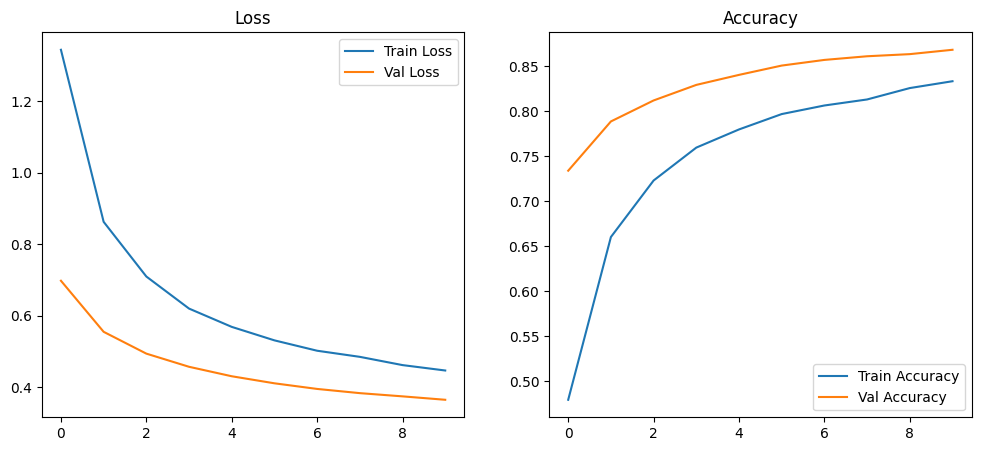

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

# 9) Evaluate on Test Set

In [9]:
results = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.8421 - loss: 0.4115
Test Loss: 0.3569, Test Accuracy: 0.8737


# 10) Save Model & Class Mapping

In [10]:
# Save the trained model in native Keras format (recommended)
model.save("/kaggle/working/brain_tumor_resnet50.keras")
print("Model saved: /kaggle/working/brain_tumor_resnet50.keras")

# Save the class mapping
import json
with open("/kaggle/working/class_mapping.json", "w") as f:
    json.dump({"classes": class_names}, f)

print("Class mapping saved: /kaggle/working/class_mapping.json")

Model saved: /kaggle/working/brain_tumor_resnet50.keras
Class mapping saved: /kaggle/working/class_mapping.json
